In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: 

Enter your authorization code:

Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Pneumonia')

In [3]:
from keras.applications.xception import Xception
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model

import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [0]:
imagesize = 150

train_batchsize = 32
val_batchsize = 32
train_dir = 'Latest_Data/train'
validation_dir = 'Latest_Data/test'

In [5]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.20,
      height_shift_range=0.20,
      horizontal_flip = True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (imagesize, imagesize),
        batch_size = train_batchsize,
        class_mode = 'categorical',
        shuffle = True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size = (imagesize, imagesize),
        batch_size = val_batchsize,
        class_mode = 'categorical',
        shuffle = True)

Found 2129 images belonging to 2 classes.
Found 975 images belonging to 2 classes.


In [0]:
path = 'keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = Xception(input_shape = (150, 150, 3), weights = path, include_top = False)

In [7]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[12:13]:
    layer.trainable = True

for layer in base_model.layers[22:23]:
    layer.trainable = True
    
for layer in base_model.layers[32:33]:
    layer.trainable = False
    
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr=1e-4),
              metrics=['acc'])

checkpoint = ModelCheckpoint('New.h5', monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

In [9]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples/train_generator.batch_size ,
      epochs = 50,
      validation_data = validation_generator,
      validation_steps = validation_generator.samples/validation_generator.batch_size,
      verbose = 1,
      callbacks = callbacks_list)

Epoch 1/50
67/66 [==============================] - 1197s 18s/step - loss: 0.7629 - acc: 0.7398 - val_loss: 0.1805 - val_acc: 0.8769

Epoch 00001: val_acc improved from -inf to 0.87692, saving model to New.h5
Epoch 2/50
67/66 [==============================] - 54s 808ms/step - loss: 0.3937 - acc: 0.8436 - val_loss: 1.1012 - val_acc: 0.7538

Epoch 00002: val_acc did not improve from 0.87692
Epoch 3/50
67/66 [==============================] - 52s 783ms/step - loss: 0.3438 - acc: 0.8685 - val_loss: 0.5795 - val_acc: 0.8708

Epoch 00003: val_acc did not improve from 0.87692
Epoch 4/50
67/66 [==============================] - 53s 788ms/step - loss: 0.3400 - acc: 0.8704 - val_loss: 1.2678 - val_acc: 0.8462

Epoch 00004: val_acc did not improve from 0.87692
Epoch 5/50
67/66 [==============================] - 52s 783ms/step - loss: 0.3098 - acc: 0.8863 - val_loss: 0.5171 - val_acc: 0.8995

Epoch 00005: val_acc improved from 0.87692 to 0.89949, saving model to New.h5
Epoch 6/50
67/66 [=========

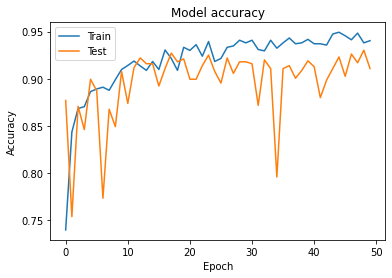

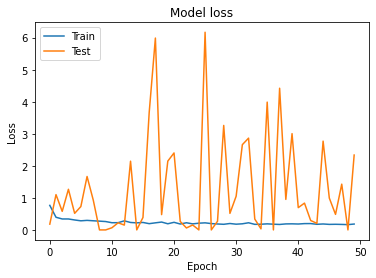

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('New Xception - Accuracy.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('New Xception - Loss.png')
plt.show()

In [11]:
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(imagesize, imagesize),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 975 images belonging to 2 classes.


In [12]:
fnames = validation_generator.filenames
ground_truth = validation_generator.classes
label2index = validation_generator.class_indices
idx2label = dict((v,k) for k,v in label2index.items())
 

predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

31/30 [==============================] - 14s 451ms/step
No of errors = 87/975


In [15]:
import pandas as pd

pre = pd.DataFrame(predictions)
pre["filename"] = validation_generator.filenames
pre["label"] = (pre["filename"].str.contains("positive")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)

#recall_score(pre["label"],pre["pre"])
print('Area under Curve is {}'.format(roc_auc_score(pre["label"],pre[1])))

Area under Curve is 0.976556331870315


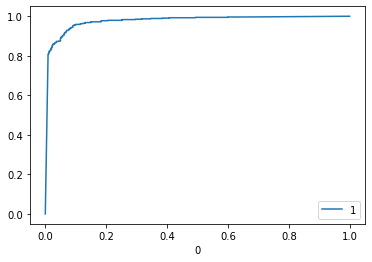

In [16]:
tpr, fpr, thres = roc_curve(pre["label"],pre[1])
roc = pd.DataFrame([tpr,fpr]).T
roc.plot(x=0,y=1)

In [0]:
img = load_img('P.jpeg', target_size=(150, 150))
img = img_to_array(img)
img = img.reshape(1, 150, 150, 3)
img = img.astype('float32')

#Prediction
r = model.predict(img)

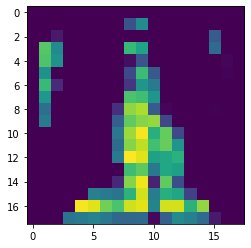

In [19]:
target_class = np.argmax(r)
last_conv = model.get_layer('conv2d_2')
grads =K.gradients(model.output[:,target_class],last_conv.output)[0]
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
pooled_grads_value,conv_layer_output = iterate([img])

for i in range(64):
    conv_layer_output[:,:,i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output,axis=-1)

for x in range(heatmap.shape[0]):
    for y in range(heatmap.shape[1]):
        heatmap[x,y] = np.max(heatmap[x,y],0)
heatmap = np.maximum(heatmap, 1)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)